In [8]:
from util import *
from expval_calc_q_optim import *
from generate_training_set import *

from qiskit.utils import QuantumInstance 
from qiskit.test.mock import FakeVigo
from qiskit import Aer, IBMQ

import matplotlib.pyplot as plt

In [17]:
# Create appropriate instances
IBMQ.save_account('2fc2fecb5ddfe847ded9ce1ba4db314b66932f993586311c514b5768a6792b3d2536e0df9885b25663b4143b99198cc88fcbb53c644b7e561ca469b770aa08dc')
IBMQ.load_account()
print(IBMQ.providers())
hardware_provider = IBMQ.get_provider(hub='ibm-q-community', group='qhack-hackathon')
hardware_backend = hardware_provider.get_backend('ibm_perth')
em_instance = QuantumInstance(backend = hardware_backend, shots = 10000)
sv_backend = Aer.get_backend('aer_simulator_statevector')
ef_instance = QuantumInstance(backend = sv_backend)

configrc.store_credentials:WARNING:2022-02-25 17:20:47,222: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-02-25 17:20:48,265: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>, <AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='default')>, <AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>, <AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='test')>]


In [18]:
# LBEM
seed = 100

group_pauli_op, [ansatz,num_par_gates] = main('H2', 0.774, 2, 1, 'simple')
group_pauli_op = group_pauli_op['grouped_paulis']
print('Ansatz & qubit hamiltonian created')

trunc_T, trunc_P = truncate_training_set(num_par_gates, 0, 0, s = seed, exhaustive= True)
circuit_list = get_circuits_dict(ansatz, trunc_T, trunc_P, num_par_gates)
print('Training circuits generated')

com_ef, com_em = expval_calc(group_pauli_op, circuit_list, em_instance, ef_instance)
print('All expectation values calculated')

q = q_optimize(group_pauli_op, circuit_list, com_em, com_ef)
print('q optimized')

Ansatz & qubit hamiltonian created
Training circuits generated
All expectation values calculated
q optimized


In [19]:
# Test using some random angles
angles = (2*np.pi/20) * np.array(list(range(20)))
efs = []
ems = []
ns = []

for angle in angles:
    ef_expval, em_expval, n_expval = test(ansatz, [angle], group_pauli_op, q, ef_instance, em_instance)
    print('Angle: {} | Error free value: {} | Error mitigated value: {} | Noisy value: {}'.format(angle, ef_expval, em_expval, n_expval))
    
    efs.append(ef_expval)
    ems.append(em_expval)
    ns.append(n_expval)

Angle: 0.0 | Error free value: (-0.7381674497530155+0j) | Error mitigated value: (-0.7538869426085755+0j) | Noisy value: (-0.6782303624254071+0j)
Angle: 0.3141592653589793 | Error free value: (-0.7203725283225795+0j) | Error mitigated value: (-0.7319789748105905+0j) | Noisy value: (-0.6534400915218953+0j)
Angle: 0.6283185307179586 | Error free value: (-0.6687296549253905+0j) | Error mitigated value: (-0.6723196143341499+0j) | Noisy value: (-0.6131701946453418+0j)
Angle: 0.9424777960769379 | Error free value: (-0.5882939938266221+0j) | Error mitigated value: (-0.5920853640880137+0j) | Noisy value: (-0.542643998845445+0j)
Angle: 1.2566370614359172 | Error free value: (-0.48693914796282656+0j) | Error mitigated value: (-0.48835797967722655+0j) | Noisy value: (-0.4558984035174996+0j)
Angle: 1.5707963267948966 | Error free value: (-0.3745864358278877+0j) | Error mitigated value: (-0.3877672280355029+0j) | Noisy value: (-0.3636589056095268+0j)
Angle: 1.8849555921538759 | Error free value: (-

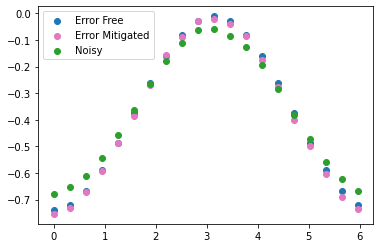

In [20]:
plt.scatter(angles, efs, c = 'tab:blue', label = 'Error Free')
plt.scatter(angles, ems, c = 'tab:pink', label = 'Error Mitigated')
plt.scatter(angles, ns, c = 'tab:green', label = 'Noisy')
plt.legend()

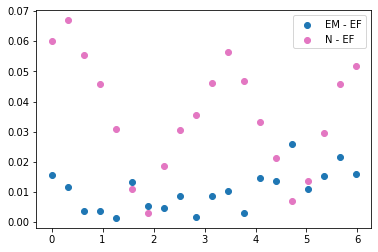

In [21]:
plt.scatter(angles, np.abs(np.array(ems) - np.array(efs)), c = 'tab:blue', label = 'EM - EF')
plt.scatter(angles, np.abs(np.array(ns) - np.array(efs)), c = 'tab:pink', label = 'N - EF')
plt.legend()